## Look Down To See the plots


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  6 15:24:06 2020

@author: Shiva
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import pandas as pd
from pandas import read_excel
from matplotlib.font_manager import FontProperties
from scipy.ndimage.interpolation import shift
import os
import glob
import timeit
from scipy import stats
import statsmodels.stats.api as sms
from matplotlib.collections import LineCollection
from tempfile import TemporaryFile
import matplotlib.gridspec as gridspec
# import numpy_indexed as npi
#print(os.path.dirname(__file__))


#############################   Plot properties   ########################################################


font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
font.set_size('20')

font_label = FontProperties()
font_label.set_family('serif')
font_label.set_name('Times New Roman')
font_label.set_style('italic')
font_label.set_size('16')


## Functions

In [97]:


def read_DLC(file_name_pos):
    ''' Read DeepLab Cut Data '''
#    file_name_pos = direct+ '/DLC/Mouse' +str(mouse_no)+ '_'+brain_region+'_alone_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_DLC.xlsx' # name of your excel file
    #file_name_pos = 'D2_#156/STR_Square_HI_1/DLC/Mouse156_STR_alone_1mW_trial37_DLC.xlsx'
    #file_name_pos = mouse_type+ '_#'+str(mouse_no)+'/'+brain_region+'_'+stim_type+'_HI_1/DLC/Mouse' +str(mouse_no)+ '_'+brain_region+'_alone_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_DLC.xlsx' # name of your excel file
    df = pd.read_excel(file_name_pos, header=[1,2])
    return df


def read_laser(file_name_laser):
    ''' Read Laser onsets offsets'''
#    file_name_laser = direct+ '/Laser/Mouse' +str(mouse_no)+ '_'+brain_region+'_alone_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_Laser.xlsx' # name of your excel file
    laser_t = pd.read_excel(file_name_laser, skiprows = 4 )
    return laser_t


def list_all_data_files(path,extension):
    '''get all the files with extention in the path where you want to search'''
    files = [x for x in os.listdir(path) if not x.startswith('.')]
    path = list(filter(lambda x: extension in x, files))
    return path

def derivative(x,delta_t):
    ''' take the derivative with delta_t '''
    derivative_out = (x - shift(x, delta_t, cval= x[0]))/ delta_t/fps*1000
    ## got crazy zith keyerror -1 
#     print(derivative_out[-1])
#     return shift(derivative_out,-int(delta_t/2),cval= derivative_out[-1])
    return shift(derivative_out,-int(delta_t/2),cval= derivative_out[len(derivative_out)-1])

def derivative_mov_ave(x,delta_t,window):
    ''' take the derivative with delta_t and do a moving average over the window'''
    derivative_out = (x - shift(x, delta_t, cval= x[0]))/ delta_t/fps*1000
    dx_dt = shift(derivative_out,-int(delta_t/2),cval= derivative_out[len(derivative_out)-1])
#     cumsum = np.cumsum(np.insert(dx_dt, 0, 0))
    moving_aver = np.convolve(dx_dt, np.ones((window,))/window, mode='valid')
    return moving_aver #(cumsum[window:] - cumsum[:-window]) / float(window) # return the moving average



def average_position(df,which_plot,where_plot):
    ''' average over right and left on the selected body parts '''
    cor_list = np.array(['x', 'y'])
    cor = cor_list[which_plot] # gets either x or y by user

    body_part_r = np.array(['rTail',  'rNose', 'rFL', 'rHL']) # all body right
    body_part_l = np.array(['lTail',  'lNose', 'lFL', 'lHL']) # all body left

    body_part_list = np.hstack((body_part_r[where_plot],body_part_l[where_plot]))

    averaged_position = df[(body_part_r[0],cor)]*0
    for param in body_part_list : # average over body parts
        averaged_position += df[(param,cor)] 
    averaged_position = averaged_position/len(body_part_list)    
    return averaged_position

def plot_what_which_where_r_l(which_plot,what_plot,where_plot):
    ''' choose which body part/
                what measure/
                for x or y
        to see the left vs. right
    '''
    label_1 = "Right" 
    label_2 = "left "
    n_timebin = 70 # number of frames for calculating velocity 
    ###%%%%%%%%%%%%%%%% |||||| Choose either x or y ||||||| %%%%%%%%%%%%%%%%%
    cor_list = np.array(['x', 'y'])
    cor = cor_list[which_plot]
    ###%%%%%%%%%%%% |||||| Choose velocity or position ||||||| %%%%%%%%%%%%%%
    plot_param_list = ['position' , 'velocity', 'acceleration']
    plot_param = plot_param_list[what_plot]
    body_part = np.array(['Tail',  'Nose', 'FL', 'HL'])
    param = body_part[where_plot[0]]
    
    plt.figure(3)
    if plot_param == 'velocity':
        
        velocity_r = derivative(df[('r'+param,cor)], n_timebin)
        velocity_l = derivative(df[('l'+param,cor)], n_timebin)
        plt.plot(time_series+n_timebin/fps, velocity_r, 'navy',label = label_1, linewidth = 0.8)
        plt.plot(time_series+n_timebin/fps, velocity_l, 'orangered',label = label_2, linewidth = 0.8)
        plt.xlim(n_timebin/fps, trial_time/2)
        plt.ylabel(cor+ " Velocity (pix)" ,fontproperties=font_label)
        min_end = min(min(velocity_r),min(velocity_l))
        max_end = max(max(velocity_r),max(velocity_l))
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
    elif plot_param == "acceleration":
        accel_r = derivative(derivative(df[('r'+param,cor)],n_timebin),n_timebin)
        accel_l = derivative(derivative(df[('l'+param,cor)],n_timebin),n_timebin)
        t_shift = n_timebin/fps/2
        plt.plot(time_series+t_shift+t_shift, accel_r, 'navy',label = label_1, linewidth = 0.8)
        plt.plot(time_series+t_shift+t_shift, accel_l, 'orangered',label = label_2, linewidth = 0.8)
        plt.xlim(t_shift+t_shift, trial_time/2)
        plt.ylabel(cor+ " Acceleration (pix)" ,fontproperties=font_label)
        min_end = min(min(accel_r),min(accel_l))
        max_end = max(max(accel_r),max(accel_l))
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
    else:
        plt.plot(time_series, df[('r'+param,cor)], 'navy', label = label_1, linewidth = 0.8)
        plt.plot(time_series, df[('l'+param,cor)], 'orangered', label = label_2, linewidth = 0.8)
        plt.xlim(0, trial_time/2)
        plt.ylabel(cor+ " (pix)" ,fontproperties=font_label)
        min_end = min(min(df[('r'+param,cor)]),min(df[('l'+param,cor)]))
        max_end = max(max(df[('r'+param,cor)]),max(df[('l'+param,cor)]))
            
        
    plt.xlabel("Time(s)" ,fontproperties=font_label)
    plt.title(plot_param+' #'+str(mouse_no),fontproperties=font)
    plt.legend(fontsize = 10)
    plt.ylim(min_end,max_end)
    plt.vlines(laser_t['ON']/fps,min_end,max_end, color = 'g', linewidth = 0.4) # plot stimulus onsets
    plt.vlines(laser_t['OFF']/fps,min_end,max_end, color = 'r', linewidth = 0.4) # plot stimulus offsets
    plt.savefig(direct+'/Mouse_trial'+str(trial_no)+'_mouse_' +str(mouse_no)+'_'+ param + '_' + plot_param + '_' +cor+ '.png',bbox_inches='tight',orientation='landscape',dpi=400)



def plot_what_which_where(which_plot,what_plot,where_plot):
    ''' choose to see averaged velocity, position or acceleration for a chosen combination of body_parts
        for either x or y
    '''
    ###%%%%%%%%%%%%%%%% |||||| User Chooses either x or y ||||||| %%%%%%%%%%%%%%%%%
    cor_list = np.array(['x', 'y'])
    cor = cor_list[which_plot] # gets either x or y by user
    ###%%%%%%%%%%%% |||||| User Chooses velocity or position ||||||| %%%%%%%%%%%%%%
    plot_param_list = ['position' , 'velocity', 'acceleration']
    plot_param = plot_param_list[what_plot]
    ########################################################################
    body_part = np.array(['Tail',  'Nose', 'FLimb', 'HLimb']) # all body left
    averaged_pos = average_position(df, which_plot,where_plot)
    
    plt.figure(4)
    if plot_param == "velocity":
        velocity = derivative(averaged_pos,n_timebin)
        plt.plot(time_series+n_timebin/fps/2, velocity, 'navy', linewidth = 0.7, label = body_part[where_plot]) # plot all body
        plt.xlim(n_timebin/fps, trial_time/2)
        plt.ylabel(cor+ " Velocity (pi/ms)" ,fontproperties=font_label)
        min_end = min(velocity)
        max_end = max(velocity)
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
    
    elif plot_param == "acceleration":
        accel = derivative(derivative(averaged_pos,n_timebin),n_timebin)
        t_shift = n_timebin/fps/2
        plt.plot(time_series+t_shift+t_shift, accel, 'navy', linewidth = 0.7, label = body_part[where_plot]) # plot all body
        plt.xlim(t_shift+t_shift, trial_time/2)
        plt.ylabel(cor+ " Acceleration (pix/(ms2))" ,fontproperties=font_label)
        min_end = min(accel)
        max_end = max(accel)
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
    else:
        plt.plot(time_series, averaged_pos, 'navy', linewidth = 0.7, label = body_part[where_plot]) # plot all body
        plt.xlim(0, trial_time/2)
        plt.ylabel(cor+ " (pix)" ,fontproperties=font_label)
        min_end = min(averaged_pos)
        max_end = max(averaged_pos)
        
    
    plt.xlabel("Time(s)" ,fontproperties=font_label)
    plt.title("Average "+plot_param+' #'+str(mouse_no)+"\n"+mouse_type+" "+opto_par,fontproperties=font)
    plt.legend(fontsize = 10)
    plt.ylim(min_end,max_end)
    plt.vlines(laser_t['ON']/fps,min_end,max_end, color = 'g', linewidth = 0.4) # plot stimulus onsets
    plt.vlines(laser_t['OFF']/fps,min_end,max_end, color = 'r', linewidth = 0.4) # plot stimulus offsets
    plt.savefig(direct+'/Mouse_trial'+str(trial_no)+'_mouse_' +str(mouse_no)+'_' +cor+ '_' +plot_param+ '_averaged_all_body.png',bbox_inches='tight',orientation='landscape',dpi=400)

def extract_epochs(bins,value,pre_interval,post_interval,interval):
    ''' extract the (pre | Laser ON | post) epochs '''

     # the start and ends of laser
#     if bins[-1,1] > len(value): # check for spontaneous trials if they are shorter than laser time stamps
#         bins = bins[bins[:,1]<=len(value),:] # keep the epochs that are included in spontaneous
    ### remove the unacceptable epochs
    duration = bins[:,1]-bins[:,0]
    acceptable = np.logical_and(duration>smallest_accep_inter,duration<largest_accep_inter)
    print("# discarded epochs =",len(acceptable)-sum(acceptable))
    bins = bins[acceptable,:]
#     print(bins[-1,1], len(value))
    ### find the epochs != interval 
    larger_intervals = (duration[acceptable])>interval # find the exterior intervals to the standard interval
    smaller_intervals = (duration[acceptable])<interval # find the inferior intervals to the min interval
    # remove or add the extra frames  to make it uniform along the different stimuli
    bins[larger_intervals,1] = bins[larger_intervals,1] - (bins[larger_intervals,1]-bins[larger_intervals,0]-interval)
    bins[smaller_intervals,1] = bins[smaller_intervals,1] + (interval-(bins[smaller_intervals,1]-bins[smaller_intervals,0]))
    bins[:,0] = bins[:,0] - pre_interval ; bins[:,1] = bins[:,1] + post_interval # extend the interval to pre and post

    take = np.hstack([np.arange(i[0],i[1]+1) for i in bins[:-1]]) # make an array with indices of laser ON 
    epochs = value[take].reshape(len(bins)-1,pre_interval+post_interval+interval+1)
#     epochs = np.take(value, sorted(set(take))).reshape(len(bins)-1,pre_interval+post_interval+interval+1) #extract the laser on epochs and reshape to (number of laser stimuli x laser On interval)
    return epochs

def input_plot():
    ''' get the specifics of the plot as input and call the plot function '''
    
    print("Select what you want to see: \n")
    print(" 1. Tail \n 2. Nose \n 3. Fore Limb \n 4. Hind Limb")
    where_plot = [int(x)-1 for x in input().split()] # ask what body part to plot
    
    print(" 1. Position \n 2. Velocity \n 3. Acceleration")
    what_plot = int(input())-1 # ask what body part to plot
    
    print(" 1. X \n 2. Y ")
    which_plot = int(input())-1 # ask what body part to plot
    
    print(" 1. Right & Left \n 2. Average")
    Average_sep_plot = int(input()) # ask what body part to plot
    
    if Average_sep_plot == 2:
        print(Average_sep_plot)
        plot_what_which_where(np.array(which_plot),np.array(what_plot),np.array(where_plot))
    else:
        plot_what_which_where_r_l(np.array(which_plot),np.array(what_plot),np.array(where_plot))
        
def get_input_cor_body_part():
    ''' ask for the body part and coordinate only from user'''
    
    print("Select for which parts you want to see the pre/On/post: \n")
    print(" 1. Tail \n 2. Nose \n 3. Fore Limb \n 4. Hind Limb")
    where_plot = [int(x)-1 for x in input().split()] # ask what body part to plot
    print(" 1. X \n 2. Y ")
    which_plot = int(input())-1 # ask what body part to plot
    return where_plot,which_plot

 ###################  looking at the pre/on/post stimulus behavior #########################
def plot_pre_on_post(epochs,epochs_spont,average):
    ''' plot (pre Laser/ON-Laser/post Laser) velocity comparison between active trials and spontaneous'''
    
    epochs_mean = np.average(epochs, axis = 0) # average over different stimuli
    epochs_sem = stats.sem(epochs, axis=0) # SEM 
    epochs_mean_spont = np.average(epochs_spont, axis = 0) # average over different stimuli
    epochs_sem_spont = stats.sem(epochs, axis=0) # SEM 
    confidence_inter = np.empty((0,2), int)
 
    for i in range (epochs.shape[1]): #calculate the two sided confidence interval for every timestep
        m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
        confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)
    confidence_inter_spont = np.empty((0,2), int)
    for i in range (epochs_spont.shape[1]):
        m = [sms.DescrStatsW(epochs_spont[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
        confidence_inter_spont = np.append(confidence_inter_spont,[[m[0][0],m[0][1]]],axis=0)
    
    #sms.DescrStatsW(epochs[i,:] for i in range (epochs.shape[0])).tconfint_mean()
#     plt.figure(mouse_no)
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    plt.plot(time_series, epochs_mean, color = 'k', label = body_part[where_plot],linestyle='-',linewidth=2)#, marker='o',markersize=1)
    #plt.fill_between(time_series, epochs_mean - epochs_sem,  epochs_mean+ epochs_sem,
    #                 color='gray', alpha=0.2)
    plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1],
                     color='gray', alpha=0.2)
    plt.plot(time_series, epochs_mean_spont, color = 'b', label = "Spontaeous")
#    plt.fill_between(time_series, epochs_mean_spont - epochs_sem_spont,  epochs_mean_spont+ epochs_sem_spont,
    #                color='b', alpha=0.2)
    plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1],
                    color='b', alpha=0.2)
    plt.axvspan(0, interval/fps, alpha=0.2, color='orange')
    plt.ylabel(" Velocity (pix/ms)", fontproperties=font_label)
    plt.xlabel("Time(s)", fontproperties=font_label)
    
    min_end = min(min(epochs_mean),min(epochs_mean_spont))
    max_end = max(max(epochs_mean),max(epochs_mean_spont))
    # plt.vlines(0,min_end,max_end, color = 'g', linewidth = 0.6)# plot stimulus onsets
    # plt.vlines(min_interval/fps,min_end,max_end, color = 'r', linewidth = 0.6)# plot stimulus offset
#     plt.ylim(min_end-abs(min_end)*.7,max_end+abs(max_end)*.7) #set limits
    plt.ylim(min_y_pre_post,max_y_pre_post) #set limits
    plt.legend(fontsize = 10)
    if average == 'n':
        plt.title(cor+ "-Velocity ("+mouse_type+") #"+str(mouse_no) +" "+opto_par+"\n"+" interval = "+ str(n_timebin) , fontproperties=font)
        plt.savefig(pre_direct+direct_comparison+'/Mouse'+str(mouse_no)+'_'+folder+"_"+opto_par+'_'+mouse_type+'_trial_' +str(trial_no)+'_spont_trial'+str(trial_spont)+'_' + cor+ '_Velociy_' +str(n_timebin)+ '_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=400)
    elif average == 'Averg_trials': # one one mouse
#         plt.title(cor+ "-Velocity ("+mouse_type+") #"+str(mouse_no) +" "+opto_par+"\n"+" interval = "+ str(n_timebin) , fontproperties=font)
        plt.title(" #"+str(mouse_no) +" "+mouse_type , fontproperties=font)
#         plt.savefig(pre_direct+direct_comparison+'/'+average+'_Mouse'+str(mouse_no)+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +str(n_timebin)+ 'spont_sampl='+str(no_sample)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=400)
    else:
        plt.title(cor+ "-Velocity ("+mouse_type+")"+"\n"+" Average of all "+opto_par+"\n"+" interval = "+ str(n_timebin) , fontproperties=font)
        plt.savefig(pre_direct+'Summary'+'/'+average+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +str(n_timebin)+ 'spont_sampl='+str(no_sample)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=400)

def epochs_single_file(file_name_pos,file_name_spont,file_name_laser):
    '''read a single file for a mouse and return the epochs'''
    
    df = read_DLC(file_name_pos)
    df_spont = read_DLC(file_name_spont)
    laser_t = read_laser(file_name_laser)


    time_series  = df.index / fps ## time axis in seconds for stimulation trial
    trial_time = max(time_series)

    time_series_spont  = df_spont.index / fps ## time axis in seconds for spontaneous activity
    trial_time_spont = max(time_series_spont)

    #input_plot() 
    velocity = derivative(average_position(df, which_plot,where_plot).values,n_timebin)  # velocity
    bins  = np.array(laser_t.values).astype(int)
    epochs = extract_epochs(bins,velocity,pre_interval,post_interval,interval)
    velocity_spont = derivative(average_position(df_spont, which_plot,where_plot).values,n_timebin)  # velocity 
    bins_spont  = np.array(laser_t.values).astype(int) # for now
    epochs_spont = extract_epochs(bins,velocity_spont,pre_interval,post_interval,interval)
    return epochs,epochs_spont

def extract_epochs_over_trials(files_list,files_list_laser,folder,spont):
    '''return all the epochs of all trials for one mouse '''
    
    i = 0
    print('spont ='+spont)
    file_path_DLC = direct+folder+'/DLC/'+files_list[i]
    print("DLC= "+files_list[i])
    df = read_DLC(file_path_DLC)
#     file_path_Laser = direct+folder+'/Laser/'+files_list[i].replace('DLC.xlsx','Laser.xlsx')

#     velocity =  derivative(average_position(df, which_plot,where_plot).values,n_timebin)  # velocity
    velocity =  derivative_mov_ave(average_position(df, which_plot,where_plot).values,n_timebin,window)  # velocity
    if spont == 'y':
        bins = produce_random_bins_for_spont(len(velocity),no_sample,max_distance,min_distance)
    else:
        file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
        print("laser= "+files_list_laser[i])
        laser_t = read_laser(file_path_Laser)
        bins  = np.array(laser_t.values).astype(int)
    epochs = extract_epochs(bins,velocity,pre_interval,post_interval,interval)

    for i in range(1,len(files_list)):
        
        print(' number of session = {} out of {}'.format(i+1,len(files_list)))
        file_path_DLC = direct+folder+'/DLC/'+files_list[i]
        print("DLC= "+files_list[i])
        df = read_DLC(file_path_DLC)
#         velocity = derivative(average_position(df, which_plot,where_plot).values,n_timebin)  # velocity
        velocity =  derivative_mov_ave(average_position(df, which_plot,where_plot).values,n_timebin,window)  # velocity
#         file_path_Laser = direct+folder+'/Laser/'+files_list[i].replace('DLC.xlsx','Laser.xlsx') #replace to get laser reading
        if spont == 'y': #if it\s a spontaneous reading extract epochs randomly 
            bins = produce_random_bins_for_spont(len(velocity),no_sample,max_distance,min_distance)
        else: # if a normal trial read bins from laser times
            file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
            print("laser= "+files_list_laser[i])
            laser_t = read_laser(file_path_Laser)
            bins  = np.array(laser_t.values).astype(int)
         
        epochs_trial = extract_epochs(bins,velocity,pre_interval,post_interval,interval)
        epochs = np.append(epochs,epochs_trial,axis = 0)
        
    return epochs

def extract_pre_laser_x_epochs_over_trials(files_list,files_list_laser,folder,spont,pre_stim_inter):
    '''return all the x positions in epochs preceding to a ON-laser of all trials for one mouse '''
    
    i = 0
    print('spont ='+spont)
    file_path_DLC = direct+folder+'/DLC/'+files_list[i]
    df = read_DLC(file_path_DLC)
#     file_path_Laser = direct+folder+'/Laser/'+files_list[i].replace('DLC.xlsx','Laser.xlsx')

    x_average = average_position(df, which_plot,where_plot).values # x positions
    if spont == 'y':
        bins = produce_random_bins_for_spont(len(velocity),no_sample,max_distance,min_distance)
    else:
        file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
        laser_t = read_laser(file_path_Laser)
        bins  = np.array(laser_t.values).astype(int)

    take = np.hstack([np.arange(i[0]-pre_stim_inter,i[0]) for i in bins[:-1]]) # make an array with indices of laser ON 
    epochs = x_average[take].reshape(len(bins)-1,pre_stim_inter)
    for i in range(1,len(files_list)):
        
        print(' number of session = {} out of {}'.format(i+1,len(files_list)))
        file_path_DLC = direct+folder+'/DLC/'+files_list[i]
        df = read_DLC(file_path_DLC)
    #     file_path_Laser = direct+folder+'/Laser/'+files_list[i].replace('DLC.xlsx','Laser.xlsx')

        x_average = average_position(df, which_plot,where_plot).values # x positions
        if spont == 'y':
            bins = produce_random_bins_for_spont(len(velocity),no_sample,max_distance,min_distance)
        else:
            file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
            laser_t = read_laser(file_path_Laser)
            bins  = np.array(laser_t.values).astype(int)

        take = np.hstack([np.arange(i[0]-pre_stim_inter,i[0]) for i in bins[:-1]]) # make an array with indices of laser ON 
        epochs_trial = x_average[take].reshape(len(bins)-1,pre_stim_inter)        
        epochs = np.append(epochs,epochs_trial,axis = 0)
        
    return epochs
def extract_pre_laser_accel_epochs_over_trials(files_list,files_list_laser,folder,spont,pre_stim_inter,n_timebin):
    '''return the acceleration in epochs of size "pre_stim_inter" preceding to a ON-laser of all trials for one mouse '''
    
    i = 0
    print('spont ='+spont)
    file_path_DLC = direct+folder+'/DLC/'+files_list[i]
    df = read_DLC(file_path_DLC)
#     file_path_Laser = direct+folder+'/Laser/'+files_list[i].replace('DLC.xlsx','Laser.xlsx')

    accel = derivative(derivative(average_position(df, which_plot,where_plot).values,n_timebin),n_timebin) # x acceleration
    if spont == 'y':
        bins = produce_random_bins_for_spont(len(velocity),no_sample,max_distance,min_distance)
    else:
        file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
        laser_t = read_laser(file_path_Laser)
        bins  = np.array(laser_t.values).astype(int)

    take = np.hstack([np.arange(i[0]-pre_stim_inter,i[0]) for i in bins[:-1]]) # make an array with indices of laser ON 
    epochs = accel[take].reshape(len(bins)-1,pre_stim_inter)
    for i in range(1,len(files_list)):
        
        print(' number of session = {} out of {}'.format(i+1,len(files_list)))
        file_path_DLC = direct+folder+'/DLC/'+files_list[i]
        df = read_DLC(file_path_DLC)
    #     file_path_Laser = direct+folder+'/Laser/'+files_list[i].replace('DLC.xlsx','Laser.xlsx')

        accel = derivative(derivative(average_position(df, which_plot,where_plot).values,n_timebin),n_timebin) # x acceleration
        if spont == 'y':
            bins = produce_random_bins_for_spont(len(velocity),no_sample,max_distance,min_distance)
        else:
            file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
            laser_t = read_laser(file_path_Laser)
            bins  = np.array(laser_t.values).astype(int)

        take = np.hstack([np.arange(i[0]-pre_stim_inter,i[0]) for i in bins[:-1]]) # make an array with indices of laser ON 
        epochs_trial = accel[take].reshape(len(bins)-1,pre_stim_inter)        
        epochs = np.append(epochs,epochs_trial,axis = 0)
        
    return epochs

def produce_random_bins_for_spont(max_time,n_sample,max_distance,min_distance):
    ''' produce a grid for start of bins then perturb to have randomly 
    spaced trials with a minimum and maximum distance between them'''
    
    half_max_distance =int(max_distance/2)
    start = pre_interval + half_max_distance # the first timebin eligible for the start of the first timebin
    end = max_time - (post_interval+interval+half_max_distance) # the last timebin eligible for the start of the last trial 
    time_points = np.arange(start, end-((end-start)%(min_distance+half_max_distance)),min_distance+half_max_distance ) # produce the grid
    perturb = np.random.randint(-half_max_distance,half_max_distance, size = (n_sample,len(time_points))) # produce the random perturbations
    start_arr = np.repeat(time_points.reshape(1,len(time_points)),n_sample,axis = 0)+perturb # perturb the starting points
    starts = (np.array(start_arr.ravel())).reshape(len(start_arr.ravel()),1)
    ends = starts+interval
    bins = np.concatenate((starts,ends),axis = 1) #stack start and ends of bins
    return bins

def min_and_mean_on_off(epochs,pre_interval,post_interval,interval,measure):
    ''' report the min or mean (specified by measure) velocity in the off-on periods'''
    
    pre = np.average(epochs[:,0:pre_interval],axis = 1).reshape(epochs.shape[0],1)
    if measure =='Mean':
        ON = np.average(epochs[:,pre_interval:pre_interval+interval],axis = 1).reshape(epochs.shape[0],1)
    elif measure =='Min':
        ON = np.min(epochs[:,pre_interval:pre_interval+interval],axis = 1).reshape(epochs.shape[0],1)
    post = np.average(epochs[:,pre_interval+interval:pre_interval+interval+post_interval],axis = 1).reshape(epochs.shape[0],1)
    average_of_on_off_on = np.concatenate((pre, ON, post), axis = 1)
    return average_of_on_off_on
    
def plot_every_mouse_mean(epochs_mean_each_mouse):
    '''plot mean of each mouse for epochs OFF-ON-OFF'''
    
    for i in range (epochs_mean_each_mouse.shape[0]):
        plt.plot(median,epochs_mean_each_mouse[i,:],'-',color = 'gray',marker = '.')

def violin_plot_summary(data_init,names,measure):
    ''' plot violin plot for different columns in data'''
    
    def adjacent_values(vals, q1, q3):
        upper_adjacent_value = q3 + (q3 - q1) * 1.5
        upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

        lower_adjacent_value = q1 - (q3 - q1) * 1.5
        lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
        return lower_adjacent_value, upper_adjacent_value


    def set_axis_style(ax, labels):
        ax.get_xaxis().set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
        ax.set_xlabel('Time Epoch')

    # transform the data into list as to be fed to the violin plot function
    data = list([data_init[:,i] for i in range(data_init.shape[1])])
    fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), sharey=True)

    ax2.set_title(mouse_type)
    parts = ax2.violinplot(
            data, showmeans=False, showmedians=False,
            showextrema=False)

    for pc in parts['bodies']:
        pc.set_facecolor('teal')
        pc.set_edgecolor('None')
        pc.set_alpha(.4)

    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    confidence_inter = np.empty((0,2), int)

    for i in range (data_init.shape[1]): #calculate the two sided confidence interval for every timestep
        m = [sms.DescrStatsW(data_init[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
        confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)
        ax2.vlines(inds[i], m[0][0], m[0][1], color='k', linestyle='-', lw=7)
        print(m[0][0]-m[0][1])

    ax2.scatter(inds, medians, marker='o', color='white', s=10, zorder=3)
    
    ax2.boxplot(inds, data, whis=confidence_inter)
    
    ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2, label = 'Quartiles')
    ax2.vlines(inds, whiskersMin, whiskersMax, color='r', linestyle='-', lw=1,label = 'Whiskers')

    # set style for the axes

    for ax in [ax2]:
        set_axis_style(ax, names)
    print(epochs_mean_each_mouse.shape)
    # plot each mouse data individually on top of the summary of all
    if measure == 'Mean':
        for i in range (epochs_mean_each_mouse.shape[0]):
            plt.plot(inds,epochs_mean_each_mouse[i,:],'-',color = 'gray',marker = '.',alpha=0.6)
    elif measure == 'Min':
        for i in range (epochs_min_each_mouse.shape[0]):
            plt.plot(inds,epochs_min_each_mouse[i,:],'-',color = 'gray',marker = '.',alpha=0.6)
            
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    plt.ylabel(" Velocity (pix/ms)", fontproperties=font_label)
    plt.xlabel("Epoch", fontproperties=font_label)
    plt.ylim(-16,30) #set limits
    plt.title(cor+ " "+measure+" Velocity"+"\n"+mouse_type+' '+opto_par +"\n"+folder, fontproperties=font)
    plt.legend(fontsize = 10)
    plt.savefig(pre_direct+'Summary'+'/Aver_of_pre_stim_post'+opto_par+'_'+folder+'_'+mouse_type+'_'+ cor+'_'+measure+ '_Velociy_' +str(n_timebin)+'_violin_plot'+'.png',bbox_inches='tight',orientation='landscape',dpi=400)


In [ ]:
def plot_limbs_WRT_tail_1_stim():
    return 0

In [164]:
# arr = np.array([[1,2], [5,7], [9,11]])
# ind = np.where(arr[:,1]-arr[:,0]>1)
# ind = np.logical_and(arr[:,1]-arr[:,0]>1,arr[:,0]>5)
# print(sum(ind))
# print(arr[~ind,:])
# print(interval)

bins = produce_random_bins_for_spont(3000,no_sample,max_distance,min_distance)


(50, 1)


## plot the average for all the mice

(576, 501)


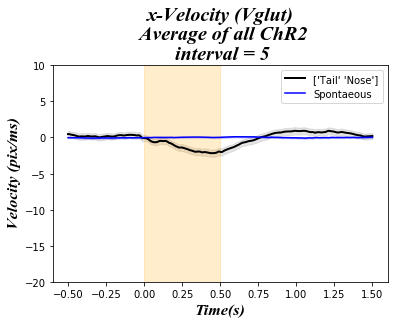

In [19]:
print(epochs_all_mice.shape)
# epochs_spont_all_mice = np.zeros((epochs_all_mice.shape))
plot_pre_on_post(epochs_all_mice,epochs_spont_all_mice,average = 'Averg_trials_all_mice')

## Dirty Main

In [3]:

#%% call functions
    
print(os.getcwd())

extension = '.xlsx' ## this is the extension you want to detect

# General parameters
opto_par = 'ChR2'
# opto_par = 'Control'
trial_no =38 # specify trial number
mouse_no = 166 # specify mouse number
stim_power = 1
trial_spont = 25 
stim_type = 'Square'
#############################################
# brain_region = 'STR'
# brain_region_alone = 'STR_alone'
# mouse_type = 'D2'
############################################
brain_region = 'STR';brain_region_alone = 'STN_alone'; mouse_type = 'Vglut'
trial_let = 'b_08' # specify trial number
trial_let_spont = 'b_02'
#############################################
# brain_region = ''
# brain_region_alone = brain_region
# mouse_type = 'FoxP2'

pre_direct = 'C:/Users/P-P1-PNH5/Desktop/Shiva_Behavior/' # folder
direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse
direct_comparison = 'Compare' # directory to the folder saving the comparison plots


#######################################################################################################################################
files_list = list_all_data_files(direct+'Spontaneous/DLC',extension)

# #################### VGlut 164-165
# file_name_spont = direct+'Spontaneous/DLC/'+mouse_type+str(mouse_no)+ '_' 'spon_act_'+ trial_let_spont+'_DLC.xlsx'
file_name_laser = direct +brain_region+'_' +stim_type+ '_HI_1'+'/Laser/'+mouse_type+str(mouse_no)+ '_'+brain_region_alone+'_'+str(stim_power)+'mW_square_pulses_'+trial_let+ '_Laser.xlsx' # name of your excel file
file_name_pos = direct+brain_region+'_' +stim_type+ '_HI_1'+ '/DLC/'+mouse_type+str(mouse_no)+ '_'+brain_region_alone+'_'+str(stim_power)+'mW_square_pulses_'+trial_let+ '_DLC.xlsx' # name of your excel file
# ##################### VGlut  116-119-166
# file_name_spont = direct+'Spontaneous/DLC/Mouse'+str(mouse_no)+'_' + 'spon_act_trial'+ str(trial_spont)+'_DLC.xlsx'
# file_name_laser = direct+brain_region+'_' +stim_type+ '_HI_1'+'/Laser/Mouse'+str(mouse_no)+ '_'+brain_region_alone+'_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_Laser.xlsx' # name of your excel file
# file_name_pos = direct+brain_region+'_' +stim_type+ '_HI_1'+ '/DLC/Mouse'+str(mouse_no)+ '_'+brain_region_alone+'_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_DLC.xlsx' # name of your excel file

# ##################### D2
# file_name_spont = direct+'Spontaneous/DLC/Mouse'+str(mouse_no)+'_' + 'spon_act_trial'+ str(trial_spont)+'_DLC.xlsx'
# file_name_laser = direct+ brain_region+'_' +stim_type+ '_HI_1'+'/Laser/Mouse'+str(mouse_no)+'_'+brain_region_alone+'_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_Laser.xlsx' # name of your excel file
# file_name_pos = direct+ brain_region+'_' +stim_type+ '_HI_1'+'/DLC/Mouse'+str(mouse_no)+'_'+brain_region_alone+'_'+str(stim_power)+'mW_trial' +str(trial_no)+'_DLC.xlsx' # name of your excel file

##################### FoxP2Cre
# file_name_spont = 'Mouse' + mouse_type+ '_#'+str(mouse_no)+'/Spontaneous/DLC/Mouse'+str(mouse_no)+'_' + 'spon_act_trial'+ str(trial_spont)+'_DLC.xlsx'
# file_name_laser = direct+ '/Laser/Mouse'+mouse_type+'_#'+str(mouse_no)+ '_'+stim_type+'Pulse_'+str(stim_power)+'mW_' +trial_let+ '_Laser.xlsx' # name of your excel file
# file_name_pos = direct+ '/DLC/Mouse#'+str(mouse_no)+ '_'+brain_region_alone'_'+stim_type+'Pulse_'+str(stim_power)+'mW_' +trial_let+ '_DLC.xlsx' # name of your excel file

#Constants
interval = 125 # number of timebins of stimulation 
fps = 250; # frame per second 
body_part = np.array(['Tail',  'Nose', 'FL', 'HL'])
cor_list = np.array(['x', 'y'])

max_distance = int(4.5*fps) # max #n_timebines between sampled epochs for spontaneous
min_distance = int(3*fps) # min #n_timebines between sampled epochs for spontaneous
no_sample = 50 # number of sets of epochs extracted from a spontaneous sequence
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset
n_timebin = 20 # number of frames for calculating velocity 
#direct = mouse_type+ '_#' +str(mouse_no)+ '/' +brain_region+'_' +stim_type+ '_HI_1' # directory to the folder containing DLC






C:\Users\P-P1-PNH5\Desktop\Shiva_Behavior\env\Scripts


## Look at a single measure in one session

Select what you want to see: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. Position 
 2. Velocity 
 3. Acceleration
1
 1. X 
 2. Y 
1
 1. Right & Left 
 2. Average
2
2


<Figure size 1080x720 with 0 Axes>

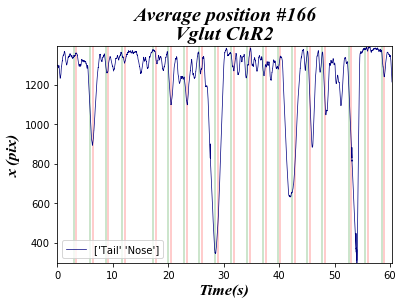

In [72]:

df = read_DLC(file_name_pos)
laser_t = read_laser(file_name_laser)
time_series  = df.index / fps ## time axis in seconds for stimulation trial
trial_time = max(time_series)

# time_series_spont  = df_spont.index / fps ## time axis in seconds for spontaneous activity
# trial_time_spont = max(time_series_spont)
fig = plt.figure(figsize=(15,10))
input_plot()
plt.show()

## Clear Main :))

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
spont =n
DLC= MouseFoxP2Cre_#8_SquarePulse_0-25mW_g01_DLC.xlsx
laser= MouseFoxP2Cre_#8_SquarePulse_0-25mW_g01_Laser.xlsx
# discarded epochs = 0
 number of session = 2 out of 2
DLC= MouseFoxP2Cre_#8_SquarePulse_0-25mW_g02_DLC.xlsx
laser= MouseFoxP2Cre_#8_SquarePulse_0-25mW_g02_Laser.xlsx
# discarded epochs = 1
run time =  16.497249100008048
spont =n
DLC= MouseFoxP2Cre_#9_SquarePulse_0-25mW_g03_DLC.xlsx
laser= MouseFoxP2Cre_#9_SquarePulse_0-25mW_g03_Laser.xlsx
# discarded epochs = 0
 number of session = 2 out of 2
DLC= MouseFoxP2Cre_#9_SquarePulse_0-25mW_g04_DLC.xlsx
laser= MouseFoxP2Cre_#9_SquarePulse_0-25mW_g04_Laser.xlsx
# discarded epochs = 0
run time =  16.340895899978932
spont =n
DLC= MouseFoxP2Cre_#10_SquarePulse_0-25mW_g07_DLC.xlsx
laser= MouseFoxP2Cre_#10_SquarePulse_0-25mW_g07_Laser.xlsx
# discarded epochs = 7
 number of session = 2 out of 2
DLC= MouseF

<Figure size 432x288 with 0 Axes>

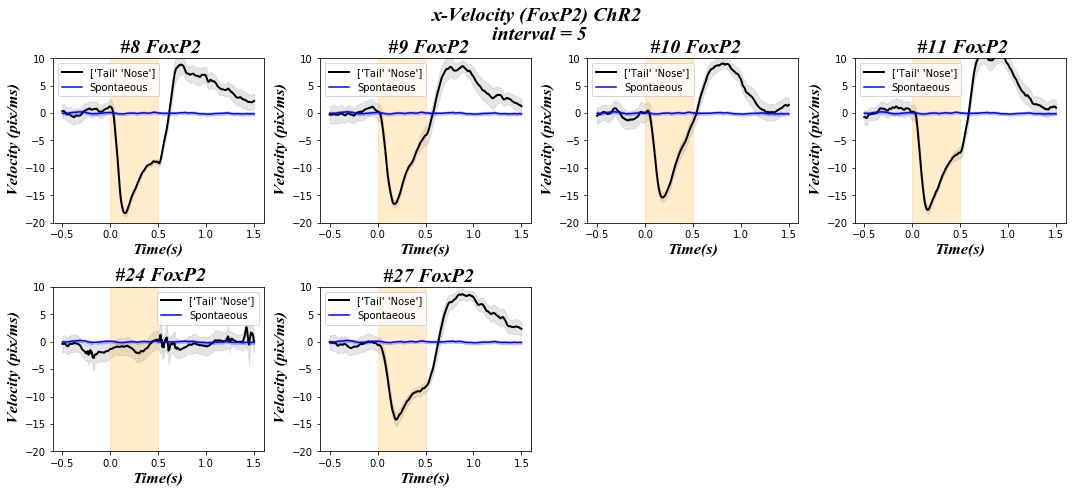

In [106]:

where_plot,which_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

################# single trial
# epochs,epochs_spont = epochs_single_file(file_name_pos,file_name_spont,file_name_laser)
# plot_pre_on_post(epochs,epochs_spont,average = 'n')
##########################################################################################
################ Average over trials
opto_par = 'ChR2'
# opto_par = 'Control'

## 1 mW intensity
folder = 'STR_Square_HI_1';  
# folder = 'STN_Square_HI_1'; #Vglut control folder's name
# folder = 'Square_HI_1';

## 0.5 mW intensity
folder = 'STR_Square_HI';  
# folder = 'STN_Square_HI'; #Vglut control folder's name
# folder = 'Square_HI';
folder= 'Square_0-5_mW'

## 0.25 mW intensity
folder = 'Square_0-25_mW'

# mouse_type = 'Vglut'
# mouse_type = 'D2';
mouse_type = 'FoxP2'
folder_spont = 'Spontaneous'

n_timebin = 5 # number of frames for calculating velocity 
window = 5 # moving average window
VGlut_list = ([116, 117, 118, 119, 164, 165, 166],[359, 360]) #first list ChR2 second Control
D2_list = ([156, 165, 166, 195, 196, 198, 199],[172, 178])
FoxP2_list = ([8, 9, 10, 11, 24, 27],[23, 26])

smallest_accep_inter = 123; largest_accep_inter = 128 # criteria for discarding the detected laser epochs
min_y_pre_post = -20 ; max_y_pre_post = 10

epochs_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
epochs_spont_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
epochs_mean_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
epochs_min_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
plt.figure(2)
fig = plt.figure(figsize=(15,10))
count = 0
for n in FoxP2_list[0][:]: # Run over all the mice
    count +=1
    start = timeit.default_timer()
    mouse_no = n
    direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse

    files_list_DLC = list_all_data_files(direct+folder+'/DLC',extension)
    files_list_Laser = list_all_data_files(direct+folder+'/Laser',extension)
#     files_list_spont = list_all_data_files(direct+folder_spont+'/DLC',extension)

    epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,folder,spont ='n') 
#     epochs_spont = extract_epochs_over_trials(files_list_spont,files_list_Laser,folder_spont,spont ='y')
    
    epochs_all_mice = np.append(epochs_all_mice, epochs, axis = 0)# construct an array of all the trial epochs of all mice
#     epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs
    
    temp = min_and_mean_on_off(epochs,pre_interval,post_interval,interval,'Mean')# get the mean value of velocity for pre-on-post intervals
    average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)# average over trialas
    epochs_mean_each_mouse = np.append(epochs_mean_each_mouse,average_of_on_off_on # construct an array with these 3values for all the mice
                                       ,axis = 0)
#     temp_2 = min_and_mean_on_off(epochs,pre_interval,post_interval,interval,'Min')
#     average_of_on_off_on_2 = np.average(temp_2,axis = 0).reshape(1,3)
#     epochs_min_each_mouse = np.append(epochs_min_each_mouse,average_of_on_off_on_2
#                                        ,axis = 0)
#     epochs_spont = np.zeros(np.shape(epochs))
    x = fig.add_subplot(3,4,count)
    plot_pre_on_post(epochs,epochs_spont,average = 'Averg_trials')
    stop = timeit.default_timer()
    print('run time = ',stop-start)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(cor+ "-Velocity ("+mouse_type+") "+opto_par+"\n"+" interval = "+ str(n_timebin) , fontproperties=font)


# plt.savefig(pre_direct+'Subplots'+'/All_together_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +str(n_timebin)+ 
#             '_spont_sampl='+str(no_sample)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=400)
plt.savefig(pre_direct+'Subplots'+'/All_together_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +str(n_timebin)+ "_moving_aver_win_"
           +str(window)+ '_spont_sampl='+str(no_sample)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=400)
plt.show()






## Save all epochs of a mouse type to .npz

In [104]:
file_name = mouse_type+'_'+opto_par+'_'+folder+"_mov_aver"
np.savez( os.path.join(pre_direct+direct_comparison, file_name),
         epochs_all_mice=epochs_all_mice,epochs_spont_all_mice=epochs_spont_all_mice,
         epochs_mean_each_mouse=epochs_mean_each_mouse)
dat = npzfile = np.load(pre_direct+direct_comparison+'/'+file_name+'.npz')
dat.files

['epochs_all_mice', 'epochs_spont_all_mice', 'epochs_mean_each_mouse']

In [91]:
def violin_plot_summary(data_init,names,measure):
    ''' plot violin plot for different columns in data'''

    def set_axis_style(ax, labels):
        ax.get_xaxis().set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
        ax.set_xlabel('Time Epoch')

    # transform the data into list as to be fed to the violin plot function
    data = list([data_init[:,i] for i in range(data_init.shape[1])])
    fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), sharey=True)

    ax2.set_title(mouse_type)
    parts = ax2.violinplot(
            data, widths=0.3, showmeans=False, showmedians=False,
            showextrema=False)

    for pc in parts['bodies']:
        pc.set_facecolor('teal')
        pc.set_edgecolor('None')
        pc.set_alpha(.4)

    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)

    inds = np.arange(1, len(medians) + 1)
    confidence_inter = np.empty((0,2), int)

    for i in range (data_init.shape[1]): #calculate the two sided confidence interval for every timestep
        m = [sms.DescrStatsW(data_init[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
        confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)

    ax2.scatter(inds,np.average(data_init,axis=0), marker='o', color='white', s=20, zorder=3, label = 'Means') # measns
    ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2, label = 'Quartiles') # quartiles

    ax2.errorbar(inds, np.average(data_init,axis=0),yerr=confidence_inter.T,fmt='none', elinewidth=2, capsize=7,
                 marker='o', color='r',label = '95% Confidence interval') # confidence interval

#     ax2.boxplot(inds, data)
#     ax2.vlines(inds, np.min(data_init,axis=0), np.max(data_init,axis=0), color='r', linestyle='-', lw=1,label = 'Whiskers')
# 
    # set style for the axes
    set_axis_style(ax, names)
    print(epochs_mean_each_mouse.shape)
    
    # plot each mouse data individually on top of the summary of all
    if measure == 'Mean':
        for i in range (epochs_mean_each_mouse.shape[0]):
            plt.plot(inds,epochs_mean_each_mouse[i,:],'-',color = 'gray',marker = 'o',fillstyle='none',markersize=10,linewidth=2,alpha=0.6)
    elif measure == 'Min':
        for i in range (epochs_min_each_mouse.shape[0]):
            plt.plot(inds,epochs_min_each_mouse[i,:],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
            
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    plt.ylabel(" Velocity (pix/ms)", fontproperties=font_label)
    plt.xlabel("Epoch", fontproperties=font_label)
    plt.ylim(-16,30) #set limits
    plt.title(cor+ " "+measure+" Velocity"+"\n"+mouse_type+' '+opto_par +"\n"+folder, fontproperties=font)
    plt.legend(fontsize = 20)
    plt.savefig(pre_direct+'Summary'+'/Aver_of_pre_stim_post'+opto_par+'_'+folder+'_'+mouse_type+'_'+ cor+'_'+measure+ '_Velociy_' +str(n_timebin)+'_violin_plot'+'.png',bbox_inches='tight',orientation='landscape',dpi=400)


## Plot the Summary of all Mice of (D2/ VGlut/ FoxP2)

data_init = (576, 3)
[[-0.10142098 -1.65100638 -0.07056439]
 [ 0.51818027 -0.96372529  0.44378915]]
[ 0.20837964 -1.30736583  0.18661238]
(6, 3)


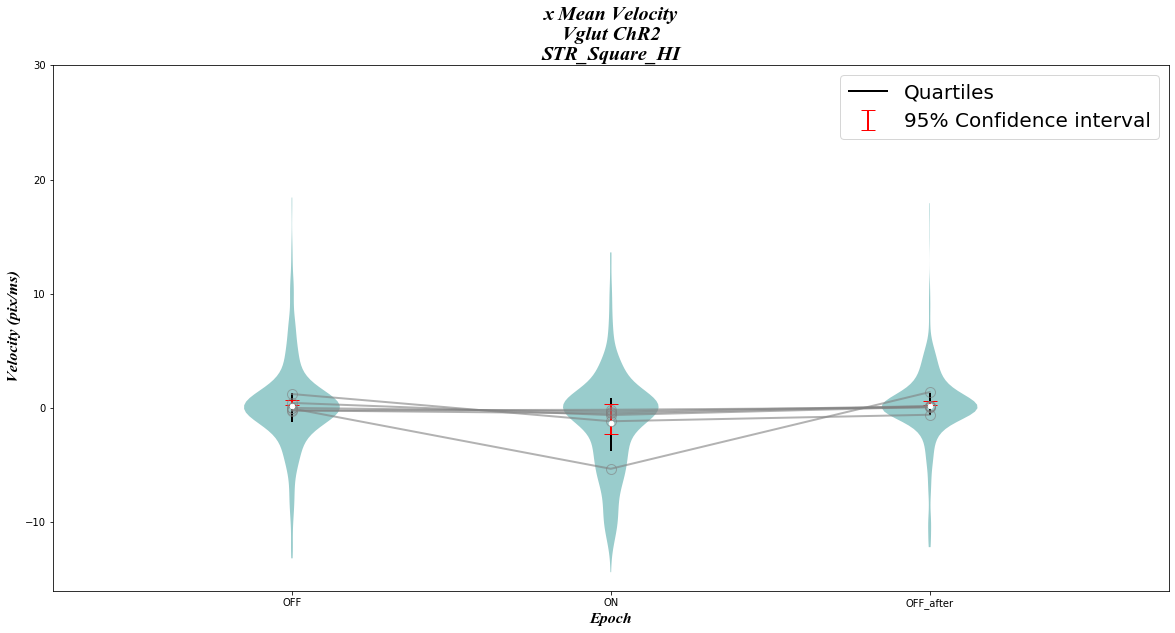

In [92]:
names = ['OFF','ON', 'OFF_after']
measure='Mean' #specify the measure for the ON-Laser Epoch
data_init =min_and_mean_on_off(epochs_all_mice,pre_interval,post_interval,interval,measure)
print('data_init =',data_init.shape)
violin_plot_summary(data_init,names,measure)
# plot_every_mouse_mean(epochs_mean_each_mouse)
plt.show()




## Plot the Pre Laser X Distribution

spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2


<Figure size 432x288 with 0 Axes>

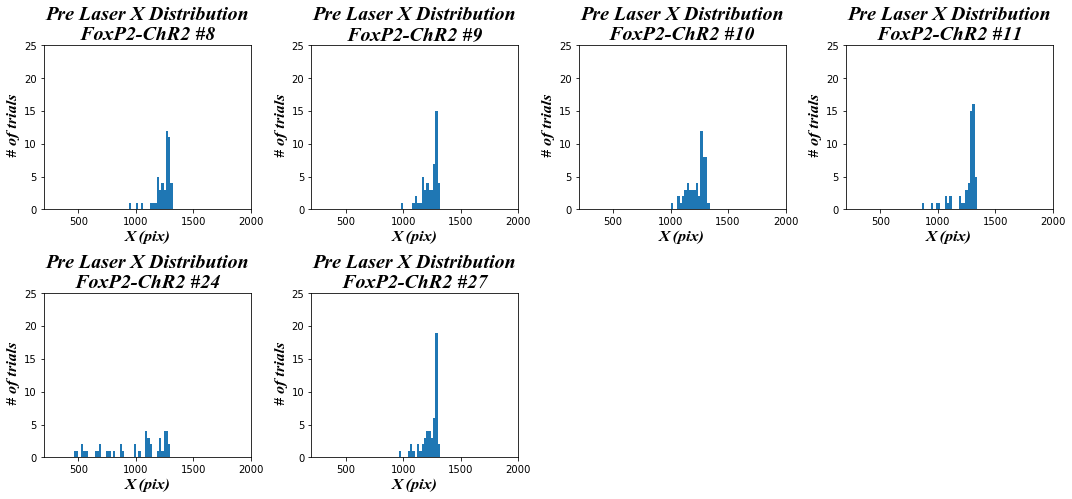

In [200]:
opto_par = 'ChR2'
# opto_par = 'Control'

## 1 mW intensity
folder = 'STR_Square_HI_1';  
# folder = 'STN_Square_HI_1'; #Vglut control folder's name
# folder = 'Square_HI_1';

## 0.5 mW intensity
folder = 'STR_Square_HI';  
# folder = 'STN_Square_HI'; #Vglut control folder's name
# folder = 'Square_HI';
# folder= 'Square_0-5_mW'

## 0.25 mW intensity
folder = 'Square_0-25_mW'

# mouse_type = 'Vglut'
# mouse_type = 'D2';
mouse_type = 'FoxP2'
folder_spont = 'Spontaneous'

pre_stim_inter = 10 # number of timebins in the pre-stimulus period 
# n_bins = 45
plt.figure(2)
fig = plt.figure(figsize=(15,10))
count = 0
min_x =200
max_y = 25 ; max_x = 2000
step = 20
bins_list = np.arange(0,max_x,step)
for n in FoxP2_list[0][:]: # Run over all the mice
    count +=1
    start = timeit.default_timer()
    mouse_no = n
    direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse

    files_list_DLC = list_all_data_files(direct+folder+'/DLC',extension)
    files_list_Laser = list_all_data_files(direct+folder+'/Laser',extension)

    pre_x_position_epochs = extract_pre_laser_x_epochs_over_trials(files_list_DLC,files_list_Laser,folder,'n', pre_stim_inter)
    pre_x_position = np.average(pre_x_position_epochs,axis = 1)
    
    x = fig.add_subplot(3,4,count)
    
    plt.hist(pre_x_position, bins=bins_list)
    plt.ylabel(" # of trials", fontproperties=font_label)
    plt.xlabel("X (pix)", fontproperties=font_label)
    plt.xlim(min_x,max_x) #set limits
    plt.ylim(0,max_y) #set limits
    plt.title("Pre Laser X Distribution"+"\n"+mouse_type+'-'+opto_par+' #'+str(mouse_no) , fontproperties=font)

plt.tight_layout()
plt.savefig(pre_direct+'Subplots'+'/Pre_laser_X_distribution_'+folder+"_"+opto_par+'_'+mouse_type+'_' +
            '.png',bbox_inches='tight',orientation='landscape',dpi=400)
plt.show()




## Categorize trials by pre-laser acceleration/position

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
spont =n
 number of session = 2 out of 3
 number of session = 3 out of 3
spont =n
 number of session = 2 out of 3
 number of session = 3 out of 3
#front=99
back=10
run time =  53.66829359999974
spont =n
 number of session = 2 out of 3
 number of session = 3 out of 3
spont =n
 number of session = 2 out of 3
 number of session = 3 out of 3
#front=117
back=4
run time =  57.03710180000053
spont =n
 number of session = 2 out of 3
 number of session = 3 out of 3
spont =n
 number of session = 2 out of 3
 number of session = 3 out of 3
#front=94
back=23
run time =  53.862135000003036
spont =n
 number of session = 2 out of 3
 number of session = 3 out of 3
spont =n
 number of session = 2 out of 3
 number of session = 3 out of 3
#front=102
back=4
run time =  50.63940189999994
spont =n
 number of session = 2 out of 3
 number of session = 3 out of 3
spont =n
 number of ses

c:\users\p-p1-pnh5\desktop\shiva_behavior\env\lib\site-packages\ipykernel_launcher.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

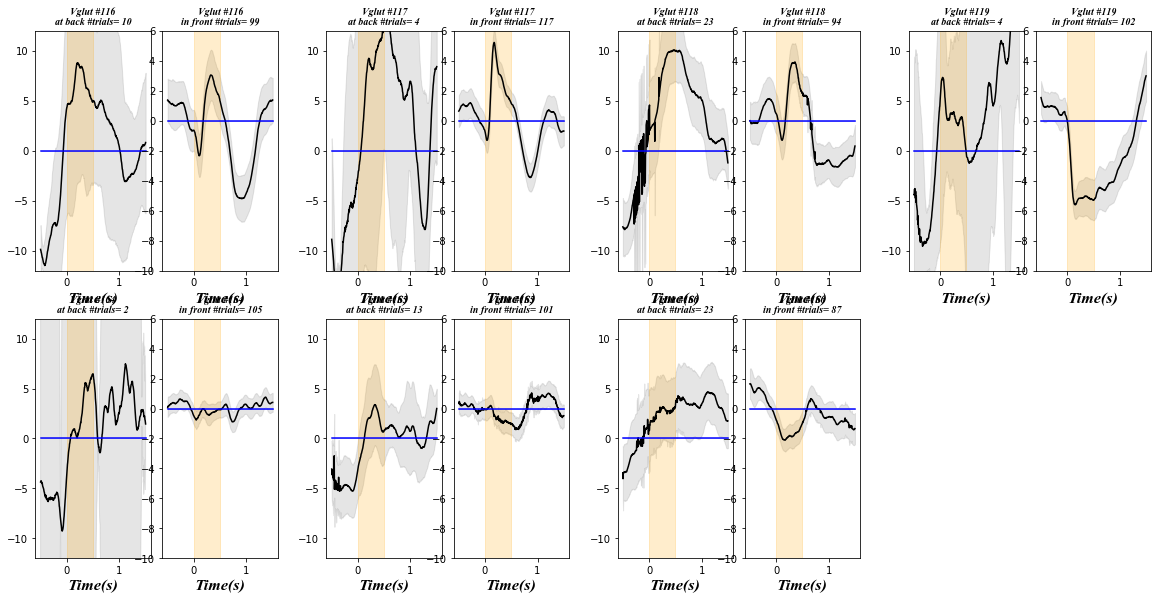

In [77]:

where_plot,which_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user


opto_par = 'ChR2'
# opto_par = 'Control'
folder = 'STR_Square_HI_1';  
# folder = 'STN_Square_HI_1'; #Vglut control folder's name
# folder = 'Square_HI_1';
mouse_type = 'Vglut'
# mouse_type = 'D2';
# mouse_type = 'FoxP2'
folder_spont = 'Spontaneous'
VGlut_list = ([116, 117, 118, 119, 164, 165, 166],[359, 360]) #first list ChR2 second Control
D2_list = ([156, 165, 166, 195, 196, 198, 199],[172, 178])
FoxP2_list = ([8, 9, 10, 11, 24, 27],[23, 26])

epochs_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
epochs_spont_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
epochs_mean_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
epochs_min_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
pre_stim_inter = 125 # number of timebins in the pre-stimulus period 
time_window = 10 # delta t to calculate the velocity and acceleration
n_bins = 45
plt.figure(2)
fig = plt.figure(figsize=(20,15))
count = 0
min_x =200
max_y = 25 ; max_x = 2000
behind_limit = 1200 # set the limit below which is considered back of the treadmill
pre_stim_inter = 2
outer = gridspec.GridSpec(3, 4, wspace=0.2, hspace=0.2)
for n in VGlut_list[0]: # Run over all the mice
    count +=1
    start = timeit.default_timer()
    mouse_no = n
    direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse

    files_list_DLC = list_all_data_files(direct+folder+'/DLC',extension)
    files_list_Laser = list_all_data_files(direct+folder+'/Laser',extension)


    epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,folder,spont ='n') 
#     epochs_spont = extract_epochs_over_trials(files_list_spont,files_list_Laser,folder_spont,spont ='y')
    
    epochs_all_mice = np.append(epochs_all_mice, epochs, axis = 0)# construct an array of all the trial epochs of all mice
#     epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs
    
#     temp = min_and_mean_on_off(epochs,pre_interval,post_interval,interval,'Mean')
#     average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
#     epochs_mean_each_mouse = np.append(epochs_mean_each_mouse,average_of_on_off_on
#                                        ,axis = 0)
    epochs_spont = np.zeros(np.shape(epochs))
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[count-1], wspace=0.1, hspace=0.1)
    
    ax = plt.Subplot(fig, inner[0])
    fig.add_subplot(ax)
    
    ## distiction by acceleration at laser onset
#     pre_accel_epochs = extract_pre_laser_accel_epochs_over_trials(files_list_DLC,files_list_Laser,folder,'n', pre_stim_inter,time_window)
#     pre_accel = np.average(pre_accel_epochs,axis = 1)
#     ind_negative_accel = np.array(np.where(pre_accel>=0)).T
#     ind_negative_accel =  ind_negative_accel.reshape( ind_negative_accel.shape[0],)
#     ind_positive_accel = np.array(np.where(pre_accel<0)).T
#     ind_positive_accel =  ind_positive_accel.reshape( ind_positive_accel.shape[0],)
#     print("#positive accel={}".format(len(ind_positive_accel)))
#     print("#negative accel={}".format(len(ind_negative_accel)))
#     plot_pre_on_post(epochs[ind_negative_accel,:],epochs_spont,average = 'Averg_trials')
#     plt.title(mouse_type+" #"+str(mouse_no) +"\n"+" interval = "+ str(time_window)+" a>0" , fontsize=10)
    
    ## distiction by x position at laser onset
    pre_x_position_epochs = extract_pre_laser_x_epochs_over_trials(files_list_DLC,files_list_Laser,folder,'n', pre_stim_inter)
    pre_x_position = np.average(pre_x_position_epochs,axis = 1)
    ind_behind_x = np.array(np.where(pre_x_position< behind_limit)).T
    ind_front_x = np.array(np.where(pre_x_position> behind_limit)).T
    ind_behind_x = ind_behind_x.reshape(ind_behind_x.shape[0],)
    ind_front_x = ind_front_x.reshape(ind_front_x.shape[0],)
    plot_pre_on_post(epochs[ind_behind_x,:],epochs_spont,average = 'Averg_trials')
    plt.title(mouse_type+" #"+str(mouse_no) +"\n"+"at back #trials= " +str(len(ind_behind_x)), fontsize=10)
    print("#front={}".format(len(ind_front_x)))
    print("back={}".format(len(ind_behind_x)))
    ax.get_legend().remove()
    plt.ylabel("")
    plt.ylim(-12,12)
    
#     x = fig.add_subplot(3,4,count)
#     epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,folder,spont ='n') 
# #     epochs_spont = extract_epochs_over_trials(files_list_spont,files_list_Laser,folder_spont,spont ='y')
    
#     epochs_all_mice = np.append(epochs_all_mice, epochs, axis = 0)# construct an array of all the trial epochs of all mice
# #     epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs
    
#     temp = min_and_mean_on_off(epochs,pre_interval,post_interval,interval,'Mean')
#     average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
#     epochs_mean_each_mouse = np.append(epochs_mean_each_mouse,average_of_on_off_on
#                                        ,axis = 0)
    
    ax = plt.Subplot(fig, inner[1])
    fig.add_subplot(ax)
    
#     plot_pre_on_post(epochs[ind_positive_accel,:],epochs_spont,average = 'Averg_trials')
#     plt.title(mouse_type+" #"+str(mouse_no) +"\n"+" interval = "+ str(time_window)+" a<0" , fontsize=10)
    
    plot_pre_on_post(epochs[ind_front_x,:],epochs_spont,average = 'Averg_trials')
    plt.title(mouse_type+" #"+str(mouse_no) +"\n"+"in front #trials= " +str(len(ind_front_x)) , fontsize=10)
    stop = timeit.default_timer()
    print('run time = ',stop-start)
    ax.get_legend().remove()
    plt.ylabel("")
    plt.ylim(-10,6)
plt.tight_layout()
# plt.savefig(pre_direct+'Subplots'+'/Pre_laser_accel_distinction_'+opto_par+'_'+mouse_type+'_' +
#             '.png',bbox_inches='tight',orientation='landscape',dpi=400)
plt.savefig(pre_direct+'Subplots'+'/Pre_laser_x_distinction_'+opto_par+'_'+mouse_type+'_' +
            '.png',bbox_inches='tight',orientation='landscape',dpi=400)
plt.show()



## Plot One mouse

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1


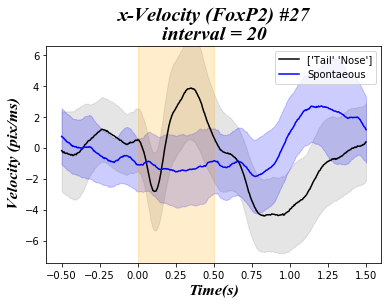

In [106]:

where_plot,which_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user
epochs,epochs_spont = epochs_single_file(file_name_pos,file_name_spont,file_name_laser)
plt.figure(1)
plot_pre_on_post(epochs,epochs_spont,average = 'n')

#a = np.empty((0,2), int)
#for i in range (epochs.shape[1]):
#    m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
#    a = np.append(a,[[m[0][0],m[0][1]]],axis=0)


## Blah Blah

In [73]:
a = np.arange(10)

take = np.hstack((np.arange(1,3),np.arange(2,6))) 
print((set(take)))
print(np.take(a, sorted(set(take))))
print(a[take])

{1, 2, 3, 4, 5}
[1 2 3 4 5]
[1 2 2 3 4 5]


In [72]:
#%% 
#################################    Spontaneous vs. Stimulated     #####################################################
################################# Tail/Nose velocity  ###############################################
#
#
####%%%%%%%%%%%%%%%% |||| Choose either Nose or Tail ||||||| %%%%%%%%%%%%%5%%
#param = 'Nose'
##param = 'Tail' 
#
####%%%%%%%%%%%%%%%% |||| Choose either x or y ||||||| %%%%%%%%%%%%%5%%
#cor = 'x'
##cor = 'y' 
###%%%%%%%%%%%%%%%%
#cor_mean_stim =  (df[('r'+param,cor)]+ df[('l'+param,cor)])/2
#velocity = (cor_mean_stim - shift(cor_mean_stim, n_timebin, cval=cor_mean_stim[0]))/ n_timebin
#
#cor_mean_spont =  (df_spont[('r'+param,cor)]+ df_spont[('l'+param,cor)])/2 # average the position of spontaneous position for left and right images
#velocity_spont = (cor_mean_spont - shift(cor_mean_spont, n_timebin, cval=cor_mean_spont[0]))/ n_timebin # velocity derived over n_timebin interval
#time_end = min(len(time_series),len(time_series_spont)) # where to end the plot 
#plt.figure(2)
#plt.plot(time_series[:time_end]+n_timebin/fps, velocity[:time_end], 'navy', linewidth = 0.8, label = 'Stimulated')
#
#plt.axhline(y = 0, color = 'r', linewidth = 0.7) # plot zero velocity threshold
#plt.plot(time_series_spont[:time_end]+n_timebin/fps, velocity_spont[:time_end], 'orange', linewidth = 0.8, label = 'Spontaneous')
#
#plt.ylabel(" Velocity (pix/s)", fontproperties=font_label)
#plt.xlabel("Time(s)", fontproperties=font_label)
#plt.title(param+' ' + cor+ " Velocity ("+ str(n_timebin) +' frame interval) #'+str(mouse_no), fontproperties=font)
#
#min_end = min(min(velocity),min(velocity_spont))
#max_end = max(max(velocity),max(velocity_spont))
#plt.ylim(min_end,max_end) #set limits
#plt.xlim(n_timebin/fps, trial_time_spont/2) # look at half of trial to see better details
#plt.vlines(laser_t['ON']/fps,min_end,max_end, color = 'gray', linewidth = 0.3)# plot stimulus onsets
#plt.legend(fontsize = 10)
#plt.savefig(direct+'/Mouse_trial'+str(trial_no)+'_mouse_' +str(mouse_no)+'_'+ param + '_' + cor+ '_Velociy_' +str(n_timebin)+ '_interval_stim_vs_spont_trial'+str(trial_spont)+'.png',bbox_inches='tight',orientation='landscape',dpi=400)
